In [38]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

IMAGE_SIZE = 416
BATCH_SIZE = 1
NUM_WORKERS = 4
DATASET = 'dataset'
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/labels/"


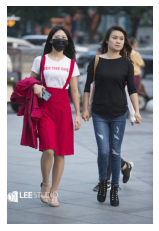

True

In [223]:
def imread(path, **kwargs):
    img = cv2.imread(path, **kwargs)
    if img is None:
        raise RuntimeError(f"Nonexisting image at path {path}")
    return img

or_image = imread("dataset/images/5265.jpg")
image=or_image



bboxes = np.roll(np.loadtxt(fname="dataset/labels/5265.txt", delimiter=" ", ndmin=2), 4, axis=1).tolist()




height, width , _= image.shape
for box in bboxes:
    p0 = (int((box[0] - box[2]/2)*width) ,int((box[1] - box[3]/2)*height))
    p1 = (int((box[0] + box[2]/2)*width) ,int((box[1] + box[3]/2)*height))
    #image =cv2.rectangle(image, p0, p1, color=(0,250,154), thickness=3)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
cv2.imwrite('original2.png',image)


In [192]:
bboxes

[[0.063, 0.246, 0.119, 0.293, 1.0],
 [0.267, 0.283, 0.076, 0.161, 1.0],
 [0.382, 0.302, 0.061, 0.123, 1.0],
 [0.521, 0.341, 0.188, 0.366, 1.0],
 [0.787, 0.247, 0.086, 0.173, 1.0],
 [0.938, 0.318, 0.117, 0.261, 1.0],
 [0.887, 0.315, 0.09, 0.208, 1.0]]

In [224]:
transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=0
        ),
        #A.OneOf(
        #    [
        #        A.ShiftScaleRotate( # Randomly apply affine transforms: translate, scale and rotate the input.
        #            rotate_limit=20, p=0, border_mode=1
        #        ),
        #        A.Affine(shear=15, p=0),
        #    ],
        #    p=1.0,
        #),
        #A.HorizontalFlip(p=1),
        #A.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.], max_pixel_value=255,),
        A.Downscale (scale_min=0.25, scale_max=0.25, interpolation=0, always_apply=True, p=1),
        #A.MotionBlur(p=1),

       
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
    
    )

In [225]:


augmentations = transforms(image=image, bboxes=bboxes)
image2 = augmentations["image"]
bboxes = augmentations["bboxes"]

True

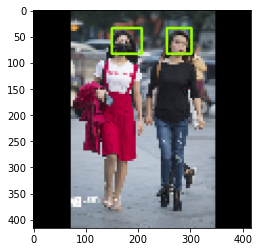

In [226]:
box=bboxes[0]



height, width , _= image2.shape
for box in bboxes:
    p0 = (int((box[0] - box[2]/2)*width) ,int((box[1] - box[3]/2)*height))
    p1 = (int((box[0] + box[2]/2)*width) ,int((box[1] + box[3]/2)*height))
    image=cv2.rectangle(image2, p0, p1, color=(0,250,154), thickness=3)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('downscale2.png',image)